## This assignment is about applying the following convolutions to train cifar10
(_And thereby learning the keras functional API_)
- Normal Convolution
- Separable Convolution 
- Depthwise Convolution
- Grouped Convolution (use 3x3, 5x5 only)
- Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)

### Import the required modules and set seed for numpy operations

In [0]:
import keras.layers
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.datasets import cifar10
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils, plot_model
import matplotlib.pyplot as plt
import numpy as np
import time

% matplotlib inline
np.random.seed(2017) 

Using TensorFlow backend.


### Examine Input Data

170500096/170498071 [==============================] - 13s 0us/step


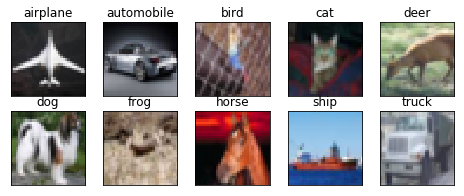

In [0]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))


class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Defining required functions:
- plotting model history
- calculating accuracy
- learning rate scheduler

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

    
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)


def scheduler(epoch, lr):
    return round(0.003 * 1/(1 + 0.319 * epoch), 10)

### Convert labels to categorical & train data to float from int

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Building a network with the functional API, using the following convolutions:
- Normal Convolution
- Separable Convolution 
- Depthwise Convolution
- Grouped Convolution (use 3x3, 5x5 only)
- Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)

In [0]:
#Input
input_layer = Input(shape=(32,32,3))                                         #Receptive Field: NA;   Input Channels: NA;  Resol:  32

#Convolution Block 1

#################### NORMAL CONVOLUTION ####################
normal_conv = Convolution2D(64, 3)(input_layer)                               #Receptive Field: 3;   Input Channels: 3;  Resol:  30
bn1 = BatchNormalization()(normal_conv)
act1 = Activation('relu')(bn1)
drp1 = Dropout(0.2)(act1)

#################### SPATIALLY SEPERABLE CONVOLUTION ####################
sp1 = Convolution2D(64, 1, 3)(drp1)                                           #Receptive Field: 3x5;   Input Channels: 64;  Resol:  30x28
bn2 = BatchNormalization()(sp1)
act2 = Activation('relu')(bn2)
drp2 = Dropout(0.2)(act2)

#################### SPATIALLY SEPERABLE CONVOLUTION ####################
sp2 = Convolution2D(128, 3, 1)(drp2)                                          #Receptive Field: 5x5;   Input Channels: 64;  Resol:  28x28
bn3 = BatchNormalization()(sp2)
act3 = Activation('relu')(bn3)
drp3 = Dropout(0.2)(act3)

#################### DEPTHWISE SEPERABLE CONVOLUTION ####################
ds1 = SeparableConv2D(filters=128, kernel_size=(3,3), depth_multiplier=2)(drp3)    #Receptive Field: 7;   Input Channels: 128;  Resol:  26x26
bn4 = BatchNormalization()(ds1)
act4 = Activation('relu')(bn4)
drp4 = Dropout(0.2)(act4)


##################### GROUPED CONV 1 - 3x3 & 5x5 #####################
gp1_3 = Convolution2D(256, 3, border_mode='same')(drp4)                           #Receptive Field: 9;   Input Channels:  128;  Resol:  26x26
bn5 = BatchNormalization()(gp1_3)
act5 = Activation('relu')(bn5)
drp5 = Dropout(0.2)(act5)

gp1_5 = Convolution2D(256, 3, border_mode='same')(drp4)                           #Receptive Field: 11;   Input Channels: 256;  Resol:  26x26
bn6 = BatchNormalization()(gp1_5)
act6 = Activation('relu')(bn6)
drp6 = Dropout(0.2)(act5)

gp1_conc = keras.layers.concatenate([drp5, drp6])                                           #Receptive Field: 11;   Input Channels: 512;  Resol:  26x26
gp1 = Convolution2D(256, 1)(gp1_conc)                                        #Receptive Field: 11;   Input Channels: 512;  Resol:  26x26


##################### GROUPED CONV 2 - 3x3 with dilation 1 & 2 #####################
gp2_dil1 = Convolution2D(256, 3, border_mode='same')(gp1)                           #Receptive Field: 13;   Input Channels:  256;  Resol:  26x26
bn7 = BatchNormalization()(gp2_dil1)
act7 = Activation('relu')(bn7)
drp7 = Dropout(0.2)(act7)

gp2_dil2 = Convolution2D(256, 3, border_mode='same', dilation_rate=2)(drp7)         #Receptive Field: 11;   Input Channels:  256;  Resol:  26x26
bn8 = BatchNormalization()(gp2_dil2)
act8 = Activation('relu')(bn8)
drp8 = Dropout(0.2)(act8)

gp2_conc = keras.layers.concatenate([drp7, drp8])                                           #Receptive Field: 13;   Input Channels: 512;  Resol:  26x26
gp2 = Convolution2D(256, 1)(gp1_conc)                                        #Receptive Field: 13;   Input Channels: 512;  Resol:  26x26



#Final Layers
mp1 = MaxPooling2D(2,2)(gp2)                                                 #Receptive Field: 26;   Input Channels: 256;  Resol:  13x13
final_conv = Convolution2D(10, 13)(mp1)
flt = Flatten()(final_conv)
output_layer = Activation('softmax')(flt)


model = Model(inputs=input_layer, outputs=output_layer)

#MODEL ARCHITECTURE SUMMARY
model.summary()
plot_model(model, to_file='convolutional_neural_network.png')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3))`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, 3, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, 3, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, 3, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, 3, dilation_rate=2, padding="same")`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 30, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 30, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

### Run the improved model

In [0]:
#Compile the model:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Callbacks
checkpointfilepath = "eva_assignment6a.hdf5"
checkpoint = ModelCheckpoint(checkpointfilepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


#Train Model
new_model_info = model.fit(train_features, train_labels, epochs=50, verbose=1, 
                                     validation_data=(test_features, test_labels), callbacks=callbacks_list)


Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 73s 1ms/step - loss: 3.1829 - acc: 0.3793 - val_loss: 1.4925 - val_acc: 0.4883

Epoch 00001: val_acc improved from -inf to 0.48830, saving model to eva_assignment6a.hdf5
Epoch 2/50
50000/50000 [==============================] - 68s 1ms/step - loss: 1.2257 - acc: 0.5731 - val_loss: 1.1650 - val_acc: 0.5984

Epoch 00002: val_acc improved from 0.48830 to 0.59840, saving model to eva_assignment6a.hdf5
Epoch 3/50
50000/50000 [==============================] - 68s 1ms/step - loss: 1.0423 - acc: 0.6401 - val_loss: 1.1915 - val_acc: 0.5953

Epoch 00003: val_acc did not improve from 0.59840
Epoch 4/50
50000/50000 [==============================] - 68s 1ms/step - loss: 0.9334 - acc: 0.6806 - val_loss: 0.9862 - val_acc: 0.6571

Epoch 00004: val_acc improved from 0.59840 to 0.65710, saving model to eva_assignment6a.hdf5
Epoch 5/50
50000/50000 [

### Check Accuracy

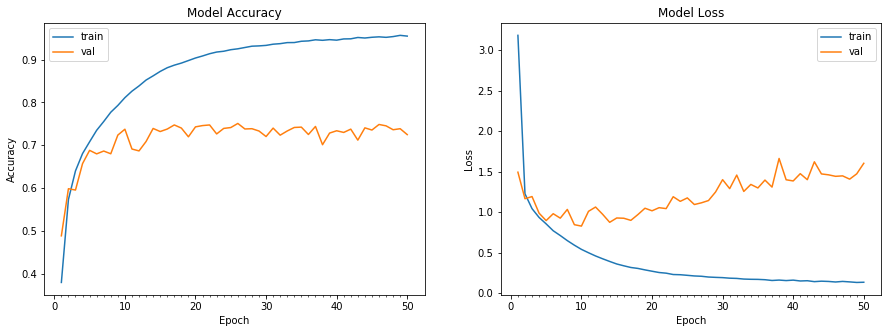

1.0930707349300384 0.751


In [0]:
plot_model_history(new_model_info)
model.load_weights(checkpointfilepath)

loss, acc = model.evaluate(test_features, test_labels, verbose=0)

#score = model.evaluate(X_test, Y_test, verbose=0)
print(loss, acc)